In [23]:
from __future__ import division
from web3 import Web3, HTTPProvider
import json

import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# Connect to the network
web3 = Web3(HTTPProvider('http://localhost:8545'))

# Get contract signature
with open('build/contracts/Energy.json') as energy_file:    
    energy_json = json.load(energy_file)
energy_abi = energy_json['abi']
network_id = energy_json['networks'].keys()[-1]
energy_address = energy_json['networks'][network_id]['address']

# List accounts and set default account
accounts = web3.eth.accounts
web3.eth.defaultAccount = account[0]
contract = web3.eth.contract(energy_abi, energy_address)

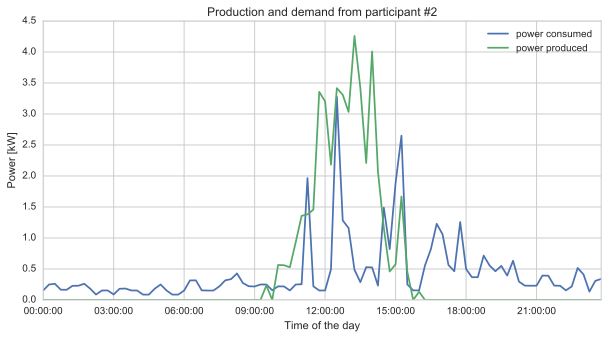

In [25]:
# Plot participant consumption and generation
account_index = 2
time_step = 15  # minutes

# Get data
consumption_filter = contract.on('addedConsumption',
                                 filter_params={'filter': {'_target': accounts[account_index]},
                                                'fromBlock': 'earliest'})
data = consumption_filter.get(only_changes=False)
data = [block for block in data if block['args']['_target'] == accounts[account_index]]
xc = pandas.date_range('2017-09-21 00:00:00', periods=len(data), freq='15T')
yc = [block['args']['_value'] / 1000 for block in data]
generation_filter = contract.on('addedGeneration',
                                 filter_params={'filter': {'_target': accounts[account_index]},
                                                'fromBlock': 'earliest'})
data = generation_filter.get(only_changes=False)
data = [block for block in data if block['args']['_target'] == accounts[account_index]]
xg = pandas.date_range('2017-09-21 00:00:00', periods=len(data), freq='15T')
yg = [block['args']['_value'] / 1000 for block in data]

# Create plot
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(xc, yc, label='power consumed')
plt.plot(xg, yg, label='power produced')
plt.title('Production and demand from participant #' + str(account_index))
plt.xlabel('Time of the day')
plt.ylabel('Power [kW]')
plt.legend(loc=0)
plt.show()

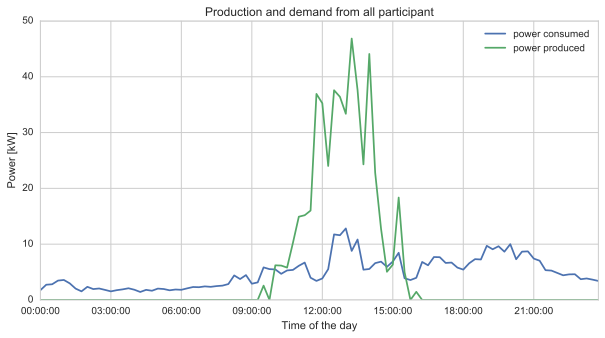

In [26]:
# Plot participant consumption and generation
time_step = 15  # minutes

# Get data
consumption_filter = contract.on('addedConsumption',
                                 filter_params={'filter': {'_target': accounts[account_index]},
                                                'fromBlock': 'earliest'})
generation_filter = contract.on('addedGeneration',
                                 filter_params={'filter': {'_target': accounts[account_index]},
                                                'fromBlock': 'earliest'})
datac = consumption_filter.get(only_changes=False)
datag = generation_filter.get(only_changes=False)

for index, account in enumerate(accounts):
    data = [block['args']['_value'] / 1000 for block in datac if block['args']['_target'] == account]
    if index == 0:
        yc = [0] * len(data)
    yc = [sum(x) for x in zip(yc, data)]

for account in accounts:
    data = [block['args']['_value'] / 1000 for block in datag if block['args']['_target'] == account]
    if index == 0:
        yg = [0] * len(data)
    yg = [sum(x) for x in zip(yg, data)]

xc = pandas.date_range('2017-09-21 00:00:00', periods=len(yc), freq='15T')
xg = pandas.date_range('2017-09-21 00:00:00', periods=len(yg), freq='15T')


# Create plot
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(xc, yc, label='power consumed')
plt.plot(xg, yg, label='power produced')
plt.title('Production and demand from all participant')
plt.xlabel('Time of the day')
plt.ylabel('Power [kW]')
plt.legend(loc=0)
plt.show()